<a href="https://colab.research.google.com/github/apricitea/klasifikasi-sms-spam/blob/main/klasifikasi-sms-spam/notebook/Project_Damin5_Spam_Message_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.7.13


# **SMS Spam or Ham**

In [ ]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 8.1 MB/s 


In [ ]:
# general purpose use
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt

# creating time function to track running time
from datetime import datetime

# nltk for word tokenizing
from nltk import sent_tokenize, download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import requests

# text preprocessing
from string import digits
from wordcloud import WordCloud
from string import punctuation
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# data preparation for modelling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# classification model
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# grid search for parameter optimization
from sklearn.model_selection import GridSearchCV

# evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## **1. Load Dataset**

In [ ]:
df = pd.read_csv('https://gist.githubusercontent.com/agtbaskara/a1a7017027cc1df9d35cf06e1e5575b7/raw/59870e27ca217d77ac0d8d8dc100551c0dcd14b3/dataset_sms_spam_v2.csv')

In [ ]:
df.head(5)

Teks  label
0  [PROMO] Beli paket Flash mulai 1GB di MY TELKO...  promo
1  2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...  promo
2  2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...  promo
3  2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...  promo
4  4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...  promo

In [ ]:
df.tail(5)

Teks   label
1138     Yooo sama2, oke nanti aku umumin di grup kelas  normal
1139  😁 sebelumnya ga ad nulis kerudung. Kirain warn...  normal
1140                               Mba mau kirim 300 ya  normal
1141  nama1  beaok bwrangkat pagi...mau cas atay tra...  normal
1142                         No bri atas nama kamu mana  normal

In [ ]:
df.isnull().sum()

Teks     0
label    0
dtype: int64

In [ ]:
df['label'].value_counts()

normal      569
penipuan    335
promo       239
Name: label, dtype: int64

In [ ]:
df['label'] = df['label'].replace(['promo','penipuan'],['spam','spam'])

In [ ]:
df['label'].value_counts()

spam      574
normal    569
Name: label, dtype: int64

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

# 1a. Pre-Cleaning Exploration

In [ ]:
x0 = df.Teks[df.label == "normal"]
x1 = df.Teks[df.label == "spam"]

In [ ]:
text0 = ' '.join(word for word in x0)
wc0 = WordCloud(colormap='Blues_r', width=800, height=800, mode='RGBA',
                background_color='white', max_words=300, collocations=False,
                prefer_horizontal=1).generate(text0)

text1 = ' '.join(word for word in x1)
wc1 = WordCloud(colormap='Reds', width=800, height=800, mode='RGBA',
                background_color='white', max_words=300, collocations=False,
                prefer_horizontal=1).generate(text1)

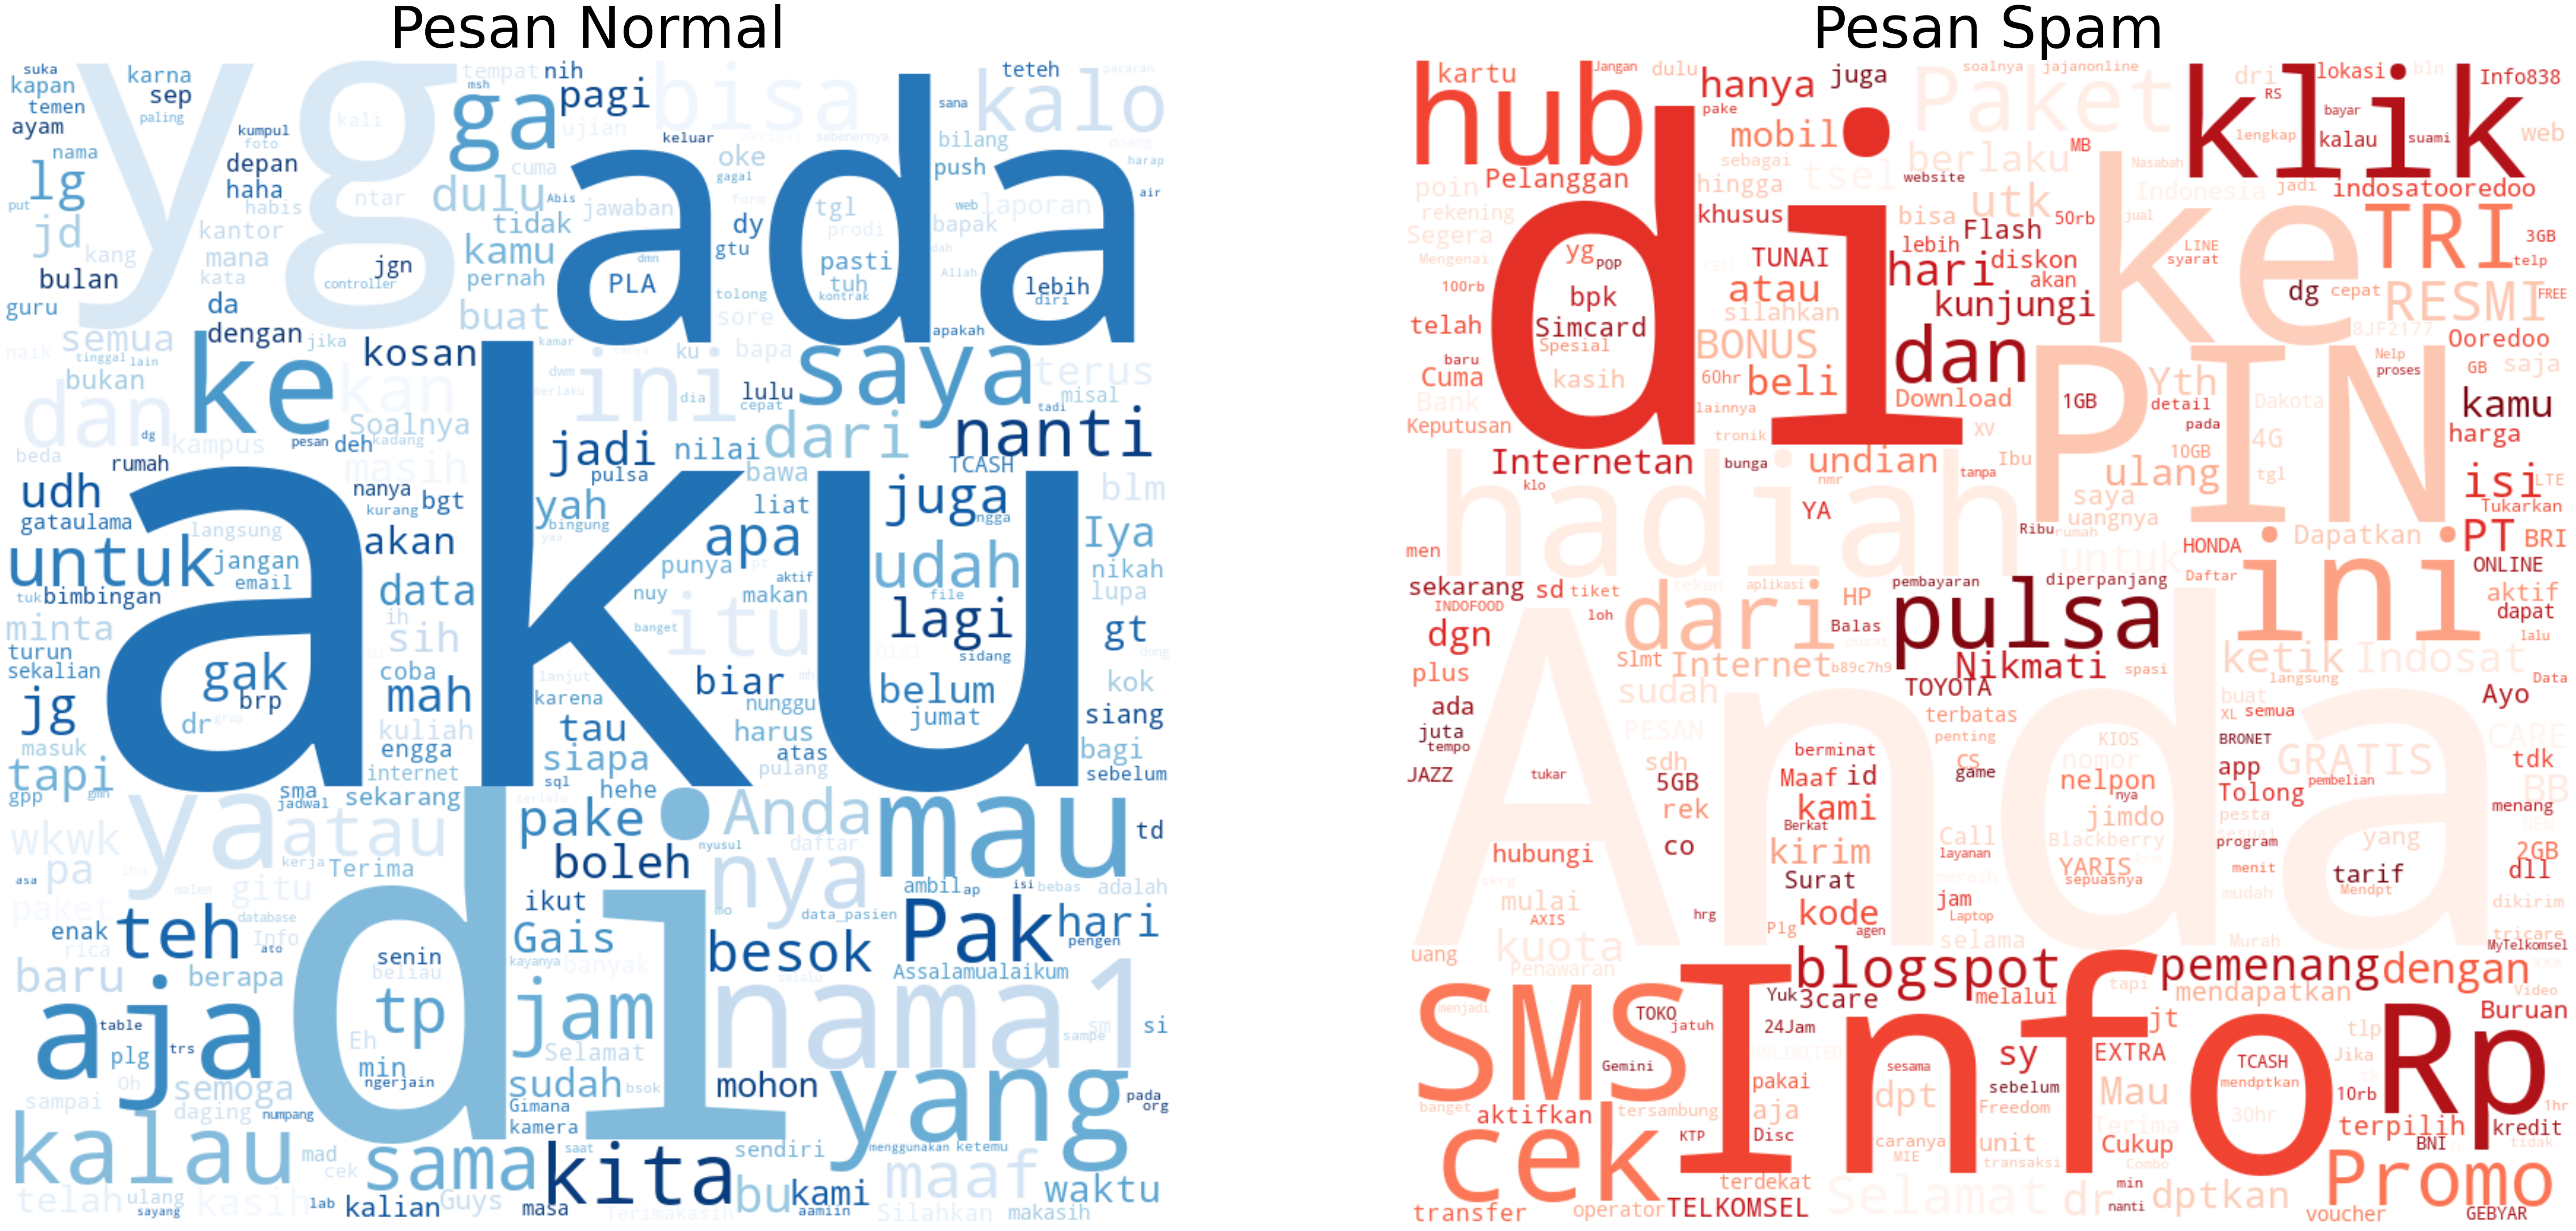

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(80, 100))

ax[0].set_title("Pesan Normal", fontsize=100)
ax[0].imshow(wc0, interpolation='bilinear')
ax[0].axis("off")
ax[0].margins(x=0, y=0)

ax[1].set_title("Pesan Spam", fontsize=100)
ax[1].imshow(wc1, interpolation='bilinear')
ax[1].axis("off")
ax[1].margins(x=0, y=0)

plt.savefig('wc.png')

## **2. Preprocessing Data**

Tahap Preprocessing:
* Convert to lowercase
* Replace double space with single space
* Remove punctuation
* Stemming (ubah kata berimbuhan menjadi kata dasar)




Berikut preprocessing data yang digunakan dan disiapkan dalam bentuk function:

In [ ]:
download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

stop_words = pd.read_csv("https://raw.githubusercontent.com/yasirabd/sentiment-dkk-semarang/main/data/stop_words.txt",header=None)

slang_1 = pd.read_csv("https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt", sep='\t', header=None, names=["slang", "formal"])
slang_2 = pd.read_csv("https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv", usecols=[0, 1])
slang_3 = pd.read_csv("https://raw.githubusercontent.com/pzidaneh/netifier/master/data/external/slangword.csv", header=0, names=["slang", "formal"])
slang = pd.concat([slang_1, slang_2, slang_3])
slang.drop_duplicates(inplace=True)
slang_dict = dict(zip(slang['slang'],slang['formal']))

def convert_to_lower_case(text):
    text = text.lower()
    return text

def remove_punctuation(text):
    for x in punctuation:
        text = text.replace(x, " ")
    return text

def remove_double_space(text):
    text = re.sub('\s+',' ',text)
    return text.strip()

def stemming(text):
    text = stemmer.stem(text)
    return text

def remove_numbers(text):
    text = text.translate(str.maketrans('', '', digits))
    return text

def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not (stop_words[0].eq(w).any())]
    return ' '.join(filtered_sentence)

def replace_slang(text):
    word_tokens = word_tokenize(text)
    filtered_sentence = [slang_dict.get(w) if w in slang_dict.keys() else w for w in word_tokens]
    return ' '.join(filtered_sentence)

def preprocessing_text(text):
    text = convert_to_lower_case(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = replace_slang(text)
    text = remove_stopwords(text)
    text = stemming(text)
    text = remove_double_space(text)
    return text

In [ ]:
start_time = timer(None)
df['cleaned_text'] = [preprocessing_text(x) for x in df['Teks']]
timer(start_time)

df.head(5)


 Time taken: 0 hours 5 minutes and 3.72 seconds.


Teks label  \
0  [PROMO] Beli paket Flash mulai 1GB di MY TELKO...  spam   
1  2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...  spam   
2  2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...  spam   
3  2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...  spam   
4  4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...  spam   

                                        cleaned_text  
0  promo beli paket flash gb my telkomsel app eks...  
1  gb rp spesial pilih aktif promo sd nov buru ak...  
2  pulang yth sisa kuota flash kb unduh mytelkoms...  
3  pulang yth sisa kuota flash kb unduh mytelkoms...  
4                 gb rp spesial pilih aktif buru skb

# 2a. Post-Cleaning Exploration

In [ ]:
text0 = ' '.join(word for word in df.cleaned_text[df.label == "normal"])
wc0 = WordCloud(colormap='Blues_r', width=800, height=800, mode='RGBA',
                background_color='white', max_words=300, collocations=False,
                prefer_horizontal=1).generate(text0)

text1 = ' '.join(word for word in df.cleaned_text[df.label == "spam"])
wc1 = WordCloud(colormap='Reds', width=800, height=800, mode='RGBA',
                background_color='white', max_words=300, collocations=False,
                prefer_horizontal=1).generate(text1)

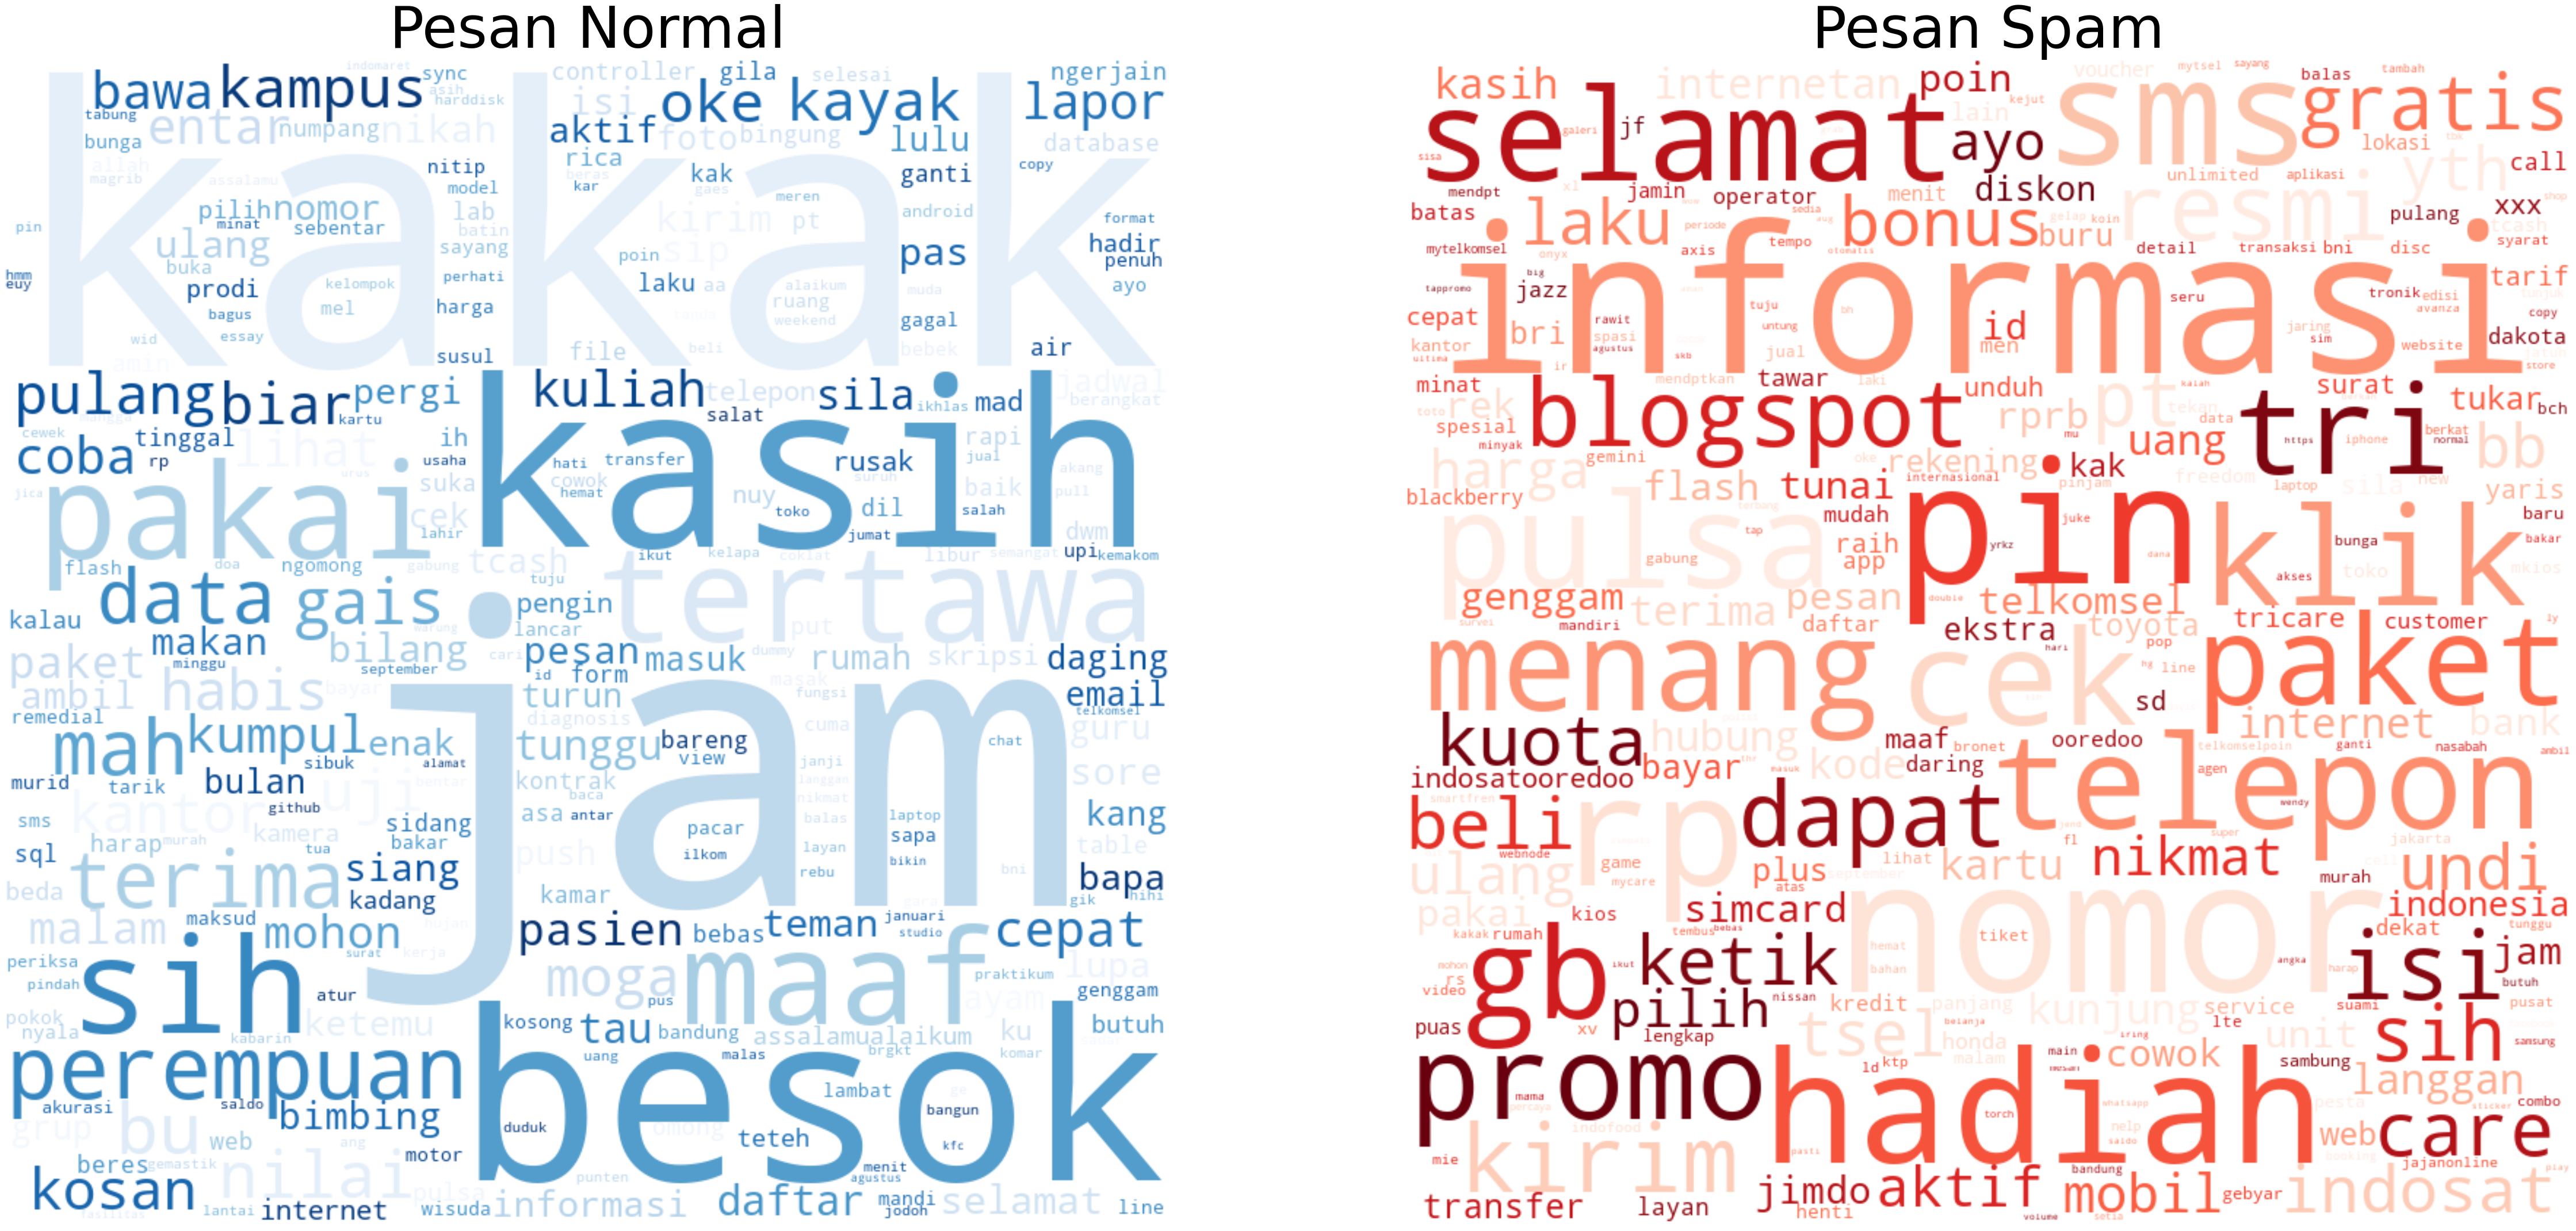

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(80, 100))

ax[0].set_title("Pesan Normal", fontsize=100)
ax[0].imshow(wc0, interpolation='bilinear')
ax[0].axis("off")
ax[0].margins(x=0, y=0)

ax[1].set_title("Pesan Spam", fontsize=100)
ax[1].imshow(wc1, interpolation='bilinear')
ax[1].axis("off")
ax[1].margins(x=0, y=0)

plt.savefig('wcap.png')

Masukkan "cleaned_text" dan "label" column masing-masing kedalam object list

In [ ]:
X = df['cleaned_text'].values.tolist()
y = df['label'].values.tolist()

Encode label / variable y menjadi numeric. Karena hanya dua kelas, maka bisa diubah menjadi 0 dan 1. Lalu buat label_map nya untuk mengembalikan nilai 0 dan 1 dalam text.

In [ ]:
labelencoder = LabelEncoder()
label = labelencoder.fit(y)

label_map = {}
for i,x in enumerate(list(label.classes_)):
  label_map.update({i:x})
print(label_map)

y = label.transform(y)

{0: 'normal', 1: 'spam'}


Split dataset menjadi data train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## **3. Vectorizing Data**

In [ ]:
vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.8)

train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

*parameter dari TfidfVectorizer

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

## **4. Building Spam Classification Model**

In [ ]:
svm_model = svm.SVC(C=5.0, gamma='auto' ,kernel='rbf', random_state=1)

start_time = timer(None)
svm_model.fit(train_vectors, y_train)
timer(start_time)


 Time taken: 0 hours 0 minutes and 0.08 seconds.


In [ ]:
svm_model.get_params()

{'C': 5.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
y_pred_svm = svm_model.predict(test_vectors)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       103
           1       1.00      0.45      0.62       126

    accuracy                           0.70       229
   macro avg       0.80      0.73      0.69       229
weighted avg       0.82      0.70      0.68       229



In [ ]:
print(confusion_matrix(y_test,y_pred_svm))

[[103   0]
 [ 69  57]]


In [ ]:
print("Accuracy:",accuracy_score(y_test, y_pred_svm))
print("F1 Score:",f1_score(y_test, y_pred_svm))
print("ROC_AUC Score:",roc_auc_score(y_test, y_pred_svm))

Accuracy: 0.6986899563318777
F1 Score: 0.6229508196721312
ROC_AUC Score: 0.7261904761904762


In [ ]:
param_grid = {'kernel':['rbf'], 'C':[0.001, 0.01, 0.1, 1, 10], 'gamma':[0.001, 0.01, 0.1, 1, 10]}

svc = svm.SVC(random_state=1)
svm_cv = GridSearchCV(estimator=svc, param_grid = param_grid, scoring='roc_auc', cv=10)
start_time = timer(None)
svm_cv.fit(train_vectors, y_train)
timer(start_time)


 Time taken: 0 hours 0 minutes and 15.5 seconds.


In [ ]:
svm_cv.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
y_pred_svm_cv = svm_cv.predict(test_vectors)

print(classification_report(y_test, y_pred_svm_cv))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       103
           1       0.98      0.98      0.98       126

    accuracy                           0.97       229
   macro avg       0.97      0.97      0.97       229
weighted avg       0.97      0.97      0.97       229



In [ ]:
print(confusion_matrix(y_test,y_pred_svm_cv))

[[100   3]
 [  3 123]]


In [ ]:
print("Accuracy:",accuracy_score(y_test, y_pred_svm_cv))
print("F1 Score:",f1_score(y_test, y_pred_svm_cv))
print("ROC_AUC Score:",roc_auc_score(y_test, y_pred_svm_cv))

Accuracy: 0.9737991266375546
F1 Score: 0.9761904761904762
ROC_AUC Score: 0.9735321312991216


## **6. Logistic Regression**

In [ ]:
logreg = LogisticRegression()

start_time = timer(None)
logreg.fit(train_vectors, y_train)
timer(start_time)


 Time taken: 0 hours 0 minutes and 0.02 seconds.


In [ ]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
y_pred_logreg = logreg.predict(test_vectors)
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       103
           1       0.98      0.97      0.98       126

    accuracy                           0.97       229
   macro avg       0.97      0.97      0.97       229
weighted avg       0.97      0.97      0.97       229



In [ ]:
print(confusion_matrix(y_test,y_pred_logreg))

[[101   2]
 [  4 122]]


In [ ]:
print("Accuracy:",accuracy_score(y_test, y_pred_logreg))
print("F1 Score:",f1_score(y_test, y_pred_logreg))
print("ROC_AUC Score:",roc_auc_score(y_test, y_pred_logreg))

Accuracy: 0.9737991266375546
F1 Score: 0.976
ROC_AUC Score: 0.9744182462629065


In [ ]:
warnings.filterwarnings('ignore')

param_grid = {'penalty':['l2'], 'C':[1,5,10], 'max_iter':[50, 100, 150],'solver':['lbfgs']}

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, scoring='roc_auc', cv=10)
start_time = timer(None)
logreg_cv.fit(train_vectors, y_train)
timer(start_time)


 Time taken: 0 hours 0 minutes and 1.8 seconds.


In [ ]:
logreg_cv.best_params_

{'C': 5, 'max_iter': 50, 'penalty': 'l2', 'solver': 'lbfgs'}

In [ ]:
y_pred_logreg_cv = logreg_cv.predict(test_vectors)

print(classification_report(y_test, y_pred_logreg_cv))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       103
           1       0.98      0.98      0.98       126

    accuracy                           0.98       229
   macro avg       0.98      0.98      0.98       229
weighted avg       0.98      0.98      0.98       229



In [ ]:
print(confusion_matrix(y_test,y_pred_logreg_cv))

[[101   2]
 [  3 123]]


In [ ]:
print("Accuracy:",accuracy_score(y_test, y_pred_logreg_cv))
print("F1 Score:",f1_score(y_test, y_pred_logreg_cv))
print("ROC_AUC Score:",roc_auc_score(y_test, y_pred_logreg_cv))

Accuracy: 0.9781659388646288
F1 Score: 0.9800796812749003
ROC_AUC Score: 0.9783865002311605


## **7. XGBoost Classifier**

In [ ]:
xgb = XGBClassifier()

start_time = timer(None)
xgb.fit(train_vectors, y_train)
timer(start_time)


 Time taken: 0 hours 0 minutes and 0.12 seconds.


In [ ]:
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
y_pred_xgb = xgb.predict(test_vectors)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       103
           1       0.98      0.93      0.96       126

    accuracy                           0.95       229
   macro avg       0.95      0.95      0.95       229
weighted avg       0.95      0.95      0.95       229



In [ ]:
print(confusion_matrix(y_test,y_pred_xgb))

[[101   2]
 [  9 117]]


In [ ]:
print("Accuracy:",accuracy_score(y_test, y_pred_xgb))
print("F1 Score:",f1_score(y_test, y_pred_xgb))
print("ROC_AUC Score:",roc_auc_score(y_test, y_pred_xgb))

Accuracy: 0.9519650655021834
F1 Score: 0.9551020408163267
ROC_AUC Score: 0.9545769764216366


In [ ]:
warnings.filterwarnings('ignore')

param = {"subsample":[0.5, 0.75, 1], "max_depth":[1, 2, 6, 12], "learning_rate":[0.5, 0.3, 0.1], "n_estimators":[50,100,150]}

xgb = XGBClassifier()
xgb_cv = GridSearchCV(xgb, param, scoring='roc_auc', cv=10)

start_time = timer(None)
xgb_cv.fit(train_vectors, y_train)
timer(start_time)


 Time taken: 0 hours 2 minutes and 38.5 seconds.


In [ ]:
xgb_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 50, 'subsample': 1}

In [ ]:
y_pred_xgb_cv = xgb_cv.predict(test_vectors)
print(classification_report(y_test, y_pred_xgb_cv))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       103
           1       0.98      0.94      0.96       126

    accuracy                           0.96       229
   macro avg       0.96      0.96      0.96       229
weighted avg       0.96      0.96      0.96       229



In [ ]:
print(confusion_matrix(y_test,y_pred_xgb_cv))

[[101   2]
 [  7 119]]


In [ ]:
print("Accuracy:",accuracy_score(y_test, y_pred_xgb_cv))
print("F1 Score:",f1_score(y_test, y_pred_xgb_cv))
print("ROC_AUC Score:",roc_auc_score(y_test, y_pred_xgb_cv))

Accuracy: 0.9606986899563319
F1 Score: 0.9635627530364373
ROC_AUC Score: 0.9625134843581445


## **8. ROC/AUC Curve**

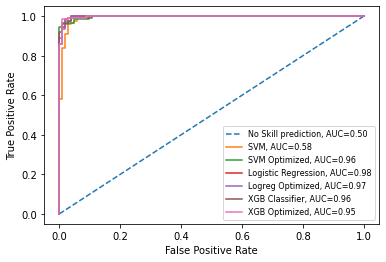

In [ ]:
# no skill prediction
y_pred_noskill = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, y_pred_noskill)

# create decision function
pred_svm = svm_model.decision_function(test_vectors)
pred_svm_cv = svm_cv.decision_function(test_vectors)
pred_logreg = logreg.decision_function(test_vectors)
pred_logreg_cv = logreg_cv.decision_function(test_vectors)
pred_xgb = xgb.predict_proba(test_vectors)[:,1]
pred_xgb_cv = xgb_cv.predict_proba(test_vectors)[:,1]

# calculate roc curves
svm_fpr, svm_tpr, _ = roc_curve(y_test, pred_svm)
svm_cv_fpr, svm_cv_tpr, _ = roc_curve(y_test, pred_svm_cv)
lgr_fpr, lgr_tpr, _ = roc_curve(y_test, pred_logreg)
lgr_cv_fpr, lgr_cv_tpr, _ = roc_curve(y_test, pred_logreg_cv)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, pred_xgb)
xgb_cv_fpr, xgb_cv_tpr, _ = roc_curve(y_test, pred_xgb_cv)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, label='No Skill prediction, AUC={:.2f}'.format(roc_auc_score(y_test, y_pred_noskill)), linestyle='--')
plt.plot(svm_fpr, svm_tpr, label='SVM, AUC={:.2f}'.format(roc_auc_score(y_test, y_pred_svm)))
plt.plot(svm_cv_fpr, svm_cv_tpr, label='SVM Optimized, AUC={:.2f}'.format(roc_auc_score(y_test, y_pred_svm_cv)))
plt.plot(lgr_fpr, lgr_tpr, label='Logistic Regression, AUC={:.2f}'.format(roc_auc_score(y_test, y_pred_logreg)))
plt.plot(lgr_cv_fpr, lgr_cv_tpr, label='Logreg Optimized, AUC={:.2f}'.format(roc_auc_score(y_test, y_pred_logreg_cv)))
plt.plot(xgb_fpr, xgb_tpr, label='XGB Classifier, AUC={:.2f}'.format(roc_auc_score(y_test, y_pred_xgb)))
plt.plot(xgb_cv_fpr, xgb_cv_tpr, label='XGB Optimized, AUC={:.2f}'.format(roc_auc_score(y_test, y_pred_xgb_cv)))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(fontsize=8)
# show the plot
plt.show()

In [ ]:
pred_result_svm = (y_test == y_pred_svm)
wrong_pred_index_svm = np.where(pred_result_svm == False)[0]

pred_result_svm_cv = (y_test == y_pred_svm_cv)
wrong_pred_index_svm_cv = np.where(pred_result_svm_cv == False)[0]

pred_result_lgr = (y_test == y_pred_logreg)
wrong_pred_index_lgr = np.where(pred_result_lgr == False)[0]

pred_result_lgr_cv = (y_test == y_pred_logreg_cv)
wrong_pred_index_lgr_cv = np.where(pred_result_lgr_cv == False)[0]

pred_result_xgb = (y_test == y_pred_xgb)
wrong_pred_index_xgb = np.where(pred_result_xgb == False)[0]

pred_result_xgb_cv = (y_test == y_pred_xgb_cv)
wrong_pred_index_xgb_cv = np.where(pred_result_xgb_cv == False)[0]

In [ ]:
wrong_pred_index_svm

array([  0,   5,   8,  12,  15,  20,  25,  26,  33,  39,  41,  42,  45,
        49,  50,  54,  56,  57,  60,  74,  76,  78,  79,  84,  85,  86,
        87,  92,  94, 104, 108, 110, 114, 120, 124, 126, 127, 128, 129,
       140, 143, 146, 151, 152, 154, 155, 159, 163, 165, 166, 170, 171,
       178, 186, 188, 193, 194, 195, 196, 200, 201, 210, 211, 213, 214,
       217, 222, 223, 225])

In [ ]:
wrong_pred_index_svm_cv

array([117, 121, 128, 174, 181, 193])

In [ ]:
wrong_pred_index_lgr

array([ 42,  60, 128, 174, 181, 217])

In [ ]:
wrong_pred_index_lgr_cv

array([ 60, 128, 174, 181, 217])

In [ ]:
wrong_pred_index_xgb

array([ 15,  42,  60,  76, 110, 121, 128, 146, 174, 181, 194])

In [ ]:
wrong_pred_index_xgb_cv

array([ 15,  42,  60, 121, 128, 146, 174, 181, 194])

In [ ]:
np.concatenate(wrong_pred_index_xgb, wrong_pred_index_xgb_cv)

TypeError: ignored

In [ ]:
w = [42,60,128,174,181]
for i in w:
  print(X_test[i])

brminat cash kredit mtor scond istmwa tipe merek mnyediakn unit dediktp yk
main gamesmu beli banyak apps apps google play store
pt pertamina persero karyawan i lulus smk sih sih kirim lamar cv ijazah photox notip email pertaminareckrutment ymail com
pin tcash sila pin nikmat layan tcash telkomsel
atur telepon seluler kirim masuk pin terima kasih
